In [ ]:
import pandas as pd
import pickle

In [ ]:
test_df  = pd.read_csv(r'/content/drive/MyDrive/datasets/test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(r'/content/drive/MyDrive/datasets/train.csv')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import random as r
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
def getdistance(df):
  for ind,row in df.iterrows():
    res_lat = abs(row['Restaurant_latitude'])
    res_long = abs(row['Restaurant_longitude'])
    del_lat = abs(row['Delivery_location_latitude'])
    del_long = abs(row['Delivery_location_longitude'])
    distance = abs(res_lat-del_lat) + abs(res_long-del_long)
    df.at[ind,'distance'] = distance*100

def diff(s1, s2):
    time1 = int(s1.replace(':',''))
    time2 = int(s2.replace(':',''))
    hourDiff = time2 // 100 - time1 // 100 - 1;
 
    minDiff = time2 % 100 + (60 - time1 % 100)
 
    if (minDiff >= 60):
        hourDiff += 1
        minDiff = minDiff - 60
 
    res = hourDiff*60  + minDiff
     
    return res

def waittime(df):
  for ind,row in df.iterrows():
    total_min = diff(row['Time_Orderd'],row['Time_Order_picked'])
    if 'Time_taken' in df.columns:
      if total_min < 0 or total_min >= row['Time_taken']-5:
        df.at[ind,'wait_time'] = row['Time_taken']*0.35
      elif total_min < 5 and row['Time_taken'] > 15:
        df.at[ind,'wait_time'] = 5
      else:
        df.at[ind,'wait_time'] = total_min
    else:
      if total_min <= 0 or total_min >= 10:
        df.at[ind,'wait_time'] = 5
      else:
        df.at[ind,'wait_time'] = total_min



In [ ]:
#data processing - 3
def df_preprocess(df):

  age_mean = round(np.nanmean(df['Delivery_person_Age']))
  df['Delivery_person_Age'].fillna(age_mean,inplace=True)

  df['multiple_deliveries'].fillna(0.0,inplace=True)

  avg_rate = np.nanmean(df['Delivery_person_Ratings'])
  df['Delivery_person_Ratings'].fillna(round(avg_rate, 1),inplace=True)

  hr = str(int(np.median(list(map(lambda x: int(str(x).split(':')[0]),df['Time_Orderd'].dropna())))))
  min=str(int(np.median(list(map(lambda x: int(str(x).split(':')[1]),df['Time_Orderd'].dropna())))))
  df['Time_Orderd'].fillna(hr+':'+min,inplace=True)

  df['Road_traffic_density'].fillna('Medium',inplace=True)

  df['Festival'].fillna('No',inplace=True)
  df['City'].fillna('Urban',inplace=True)

  w_types  = df['Weather'].dropna().unique()
  for ind, row in df[df['Weather'].isna()].iterrows():
    df.at[ind,'Weather']  = r.choice(w_types)



  df.drop(['Unnamed: 0','Name:','ID'],inplace =True,axis= 1)

  getdistance(df)
  waittime(df)

  df = pd.concat([df, pd.get_dummies(df['City'],drop_first = True)],axis=1)

  df = pd.concat([df, pd.get_dummies(df['Type_of_order'],drop_first = True)],axis=1)

  df = pd.concat([df, pd.get_dummies(df['Weather'],drop_first = True)],axis=1)

  df = pd.concat([df, pd.get_dummies(df['Road_traffic_density'],drop_first = True)],axis=1)

  df = pd.concat([df, pd.get_dummies(df['Type_of_vehicle'],drop_first = True)],axis=1)

  df.drop(['Restaurant_latitude','Delivery_person_ID','Type_of_order','Type_of_vehicle','Restaurant_longitude','Weather','Road_traffic_density','City','Delivery_location_latitude','Delivery_location_longitude','Time_Orderd','Time_Order_picked','Order_Date'],axis=1,inplace=True)
  return df

def df_transform(df):

  if 'Time_taken' in df.columns:
  
    Festival_le = LabelEncoder()
    df['Festival'] = Festival_le.fit_transform(df['Festival'])
    pickle.dump(Festival_le,open( r'/content/drive/MyDrive/datasets/Festival_le.pkl', "wb" ))

    # Delivery_person_id_le = LabelEncoder()
    # df['Delivery_person_ID'] = Delivery_person_id_le.fit_transform(df['Delivery_person_ID'])
    # pickle.dump(Delivery_person_id_le,open( r'/content/drive/MyDrive/datasets/Delivery_person_id_le.pkl', "wb" ))

    
    train_SS = StandardScaler()
    df = train_SS.fit_transform(df.drop(['Time_taken'],axis=1))

    pickle.dump(train_SS,open( r'/content/drive/MyDrive/datasets/train_SS.pkl', "wb" ))
    return df
  else:

    train_SS=pickle.load(open( r'/content/drive/MyDrive/datasets/train_SS.pkl', "rb" ))
    Festival_le =  pickle.load(open( r'/content/drive/MyDrive/datasets/Festival_le.pkl', "rb" ))
    # Delivery_person_id_le = pickle.load(open( r'/content/drive/MyDrive/datasets/Delivery_person_id_le.pkl', "rb" ))
    df['Festival'] = Festival_le.transform(df['Festival'])
    # df['Delivery_person_ID'] = Delivery_person_id_le.fit_transform(df['Delivery_person_ID'])
    df = train_SS.transform(df)
    return df
  

def predict(df):
  model = pickle.load(open( r'/content/drive/MyDrive/datasets/trained_model.pkl', "rb" ))
  return model.predict(df)



In [ ]:
train_df = df_preprocess(train_df)
y = train_df['Time_taken']
train_df.head()
train_df = df_transform(train_df)

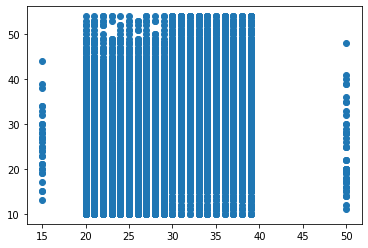

In [ ]:
#train_df[['Delivery_person_Age','Time_taken']].corr()
plt.scatter(train_df['Delivery_person_Age'],train_df['Time_taken'])
plt.show()

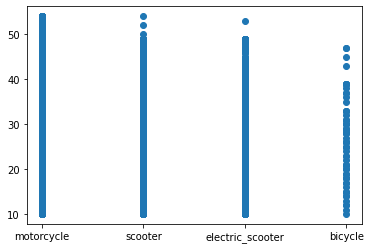

In [ ]:
plt.scatter(train_df['Type_of_vehicle'],train_df['Time_taken'])
plt.show()

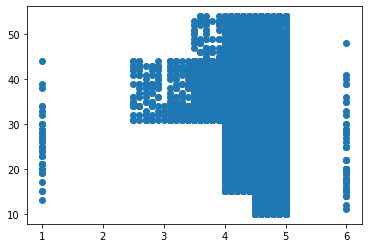

In [ ]:
plt.scatter(train_df['Delivery_person_Ratings'],train_df['Time_taken'])
plt.show()

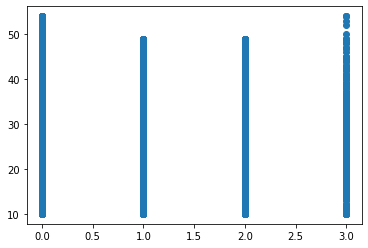

In [ ]:
plt.scatter(train_df['Vehicle_condition'],train_df['Time_taken'])
plt.show()

In [ ]:
train_df[train_df['Type_of_vehicle'] == 'bicycle'].i

,Unnamed: 0,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,...,Weather,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,Name:
1142,1142,0x1066,MYSRES05DEL01,NaN,NaN,12.323978,76.627961,12.363978,76.667961,19-03-2022,...,NaN,NaN,3,Meal,bicycle,0.0,No,Metropolitian,28.0,object
1378,1378,0x444,JAPRES01DEL01,NaN,NaN,-26.905190,-75.810753,26.975190,75.880753,04-04-2022,...,NaN,NaN,3,Meal,bicycle,1.0,No,Metropolitian,37.0,object
1624,1624,0x812,JAPRES09DEL01,NaN,NaN,26.911378,75.789034,26.921378,75.799034,24-03-2022,...,NaN,NaN,3,Buffet,bicycle,1.0,No,Metropolitian,13.0,object
1681,1681,0x429,HYDRES11DEL03,NaN,NaN,17.430448,78.418213,17.490448,78.478213,17-03-2022,...,NaN,NaN,3,Buffet,bicycle,0.0,No,Metropolitian,18.0,object
1961,1961,0xbf39,BHPRES12DEL01,NaN,NaN,0.000000,0.000000,0.040000,0.040000,13-02-2022,...,NaN,NaN,3,Buffet,bicycle,1.0,No,Metropolitian,47.0,object
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42829,42829,0x492,VADRES19DEL02,NaN,NaN,22.311844,73.165081,22.441844,73.295081,02-03-2022,...,NaN,NaN,3,Meal,bicycle,1.0,Yes,Metropolitian,47.0,object
43164,43164,0x43b,PUNERES13DEL02,NaN,NaN,-18.562450,-73.916619,18.612450,73.966619,19-03-2022,...,NaN,NaN,3,Snack,bicycle,NaN,No,Metropolitian,37.0,object
43407,43407,0x409,JAPRES18DEL03,NaN,NaN,26.913987,75.752891,27.003987,75.842891,08-03-2022,...,NaN,NaN,3,Drinks,bicycle,1.0,No,NaN,31.0,object
45067,45067,0xbeff,BHPRES15DEL01,NaN,NaN,23.234249,77.434007,23.344249,77.544007,14-02-2022,...,NaN,NaN,3,Drinks,bicycle,1.0,No,Metropolitian,39.0,object


In [ ]:
#data processing - 2
def df_preprocess(df):

  age_mean = round(np.nanmean(df['Delivery_person_Age']))
  df['Delivery_person_Age'].fillna(age_mean,inplace=True)

  df['multiple_deliveries'].fillna(0.0,inplace=True)

  avg_rate = np.nanmean(df['Delivery_person_Ratings'])
  df['Delivery_person_Ratings'].fillna(round(avg_rate, 1),inplace=True)

  hr = str(int(np.median(list(map(lambda x: int(str(x).split(':')[0]),df['Time_Orderd'].dropna())))))
  min=str(int(np.median(list(map(lambda x: int(str(x).split(':')[1]),df['Time_Orderd'].dropna())))))
  df['Time_Orderd'].fillna(hr+':'+min,inplace=True)

  df['Road_traffic_density'].fillna('Medium',inplace=True)

  df['Festival'].fillna('No',inplace=True)
  df['City'].fillna('Urban',inplace=True)

  w_types  = df['Weather'].dropna().unique()
  for ind, row in df[df['Weather'].isna()].iterrows():
    df.at[ind,'Weather']  = r.choice(w_types)



  df.drop(['Unnamed: 0','Name:','ID','Delivery_person_ID','Type_of_order'],inplace =True,axis= 1)

  getdistance(df)
  waittime(df)

  df = pd.concat([df, pd.get_dummies(df['City'],drop_first = True)],axis=1)

  df = pd.concat([df, pd.get_dummies(df['Weather'],drop_first = True)],axis=1)

  df = pd.concat([df, pd.get_dummies(df['Road_traffic_density'],drop_first = True)],axis=1)

  df.drop(['Restaurant_latitude','Restaurant_longitude','Weather','Road_traffic_density','City','Delivery_location_latitude','Delivery_location_longitude','Time_Orderd','Time_Order_picked','Order_Date'],axis=1,inplace=True)
  return df

def df_transform(df):

  if 'Time_taken' in df.columns:
  
    Festival_le = LabelEncoder()
    df['Festival'] = Festival_le.fit_transform(df['Festival'])
    pickle.dump(Festival_le,open( r'/content/drive/MyDrive/datasets/Festival_le.pkl', "wb" ))

    Type_of_vehicle_le = LabelEncoder()
    df['Type_of_vehicle'] = Type_of_vehicle_le.fit_transform(df['Type_of_vehicle'])
    pickle.dump(Type_of_vehicle_le,open( r'/content/drive/MyDrive/datasets/Type_of_vehicle_le.pkl', "wb" ))
    
    train_SS = StandardScaler()
    df = train_SS.fit_transform(df.drop(['Time_taken'],axis=1))

    pickle.dump(train_SS,open( r'/content/drive/MyDrive/datasets/train_SS.pkl', "wb" ))
    return df
  else:

    Type_of_vehicle_le=pickle.load(open( r'/content/drive/MyDrive/datasets/Type_of_vehicle_le.pkl', "rb" ))
    train_SS=pickle.load(open( r'/content/drive/MyDrive/datasets/train_SS.pkl', "rb" ))
    Festival_le =  pickle.load(open( r'/content/drive/MyDrive/datasets/Festival_le.pkl', "rb" ))
    df['Festival'] = Festival_le.transform(df['Festival'])
    df['Type_of_vehicle'] = Type_of_vehicle_le.transform(df['Type_of_vehicle'])
    df = train_SS.transform(df)
    return df
  

def predict(df):
  model = pickle.load(open( r'/content/drive/MyDrive/datasets/trained_model.pkl', "rb" ))
  return model.predict(df)



   Delivery_person_Age  Delivery_person_Ratings  Vehicle_condition  \
0                 37.0                      4.9                  2   
1                 34.0                      4.5                  2   
2                 23.0                      4.4                  0   
3                 38.0                      4.7                  0   
4                 32.0                      4.6                  1   

  Type_of_vehicle  multiple_deliveries Festival  Time_taken  distance  \
0      motorcycle                  0.0       No        24.0       4.0   
1         scooter                  1.0       No        33.0      26.0   
2      motorcycle                  1.0       No        26.0       2.0   
3      motorcycle                  1.0       No        21.0      10.0   
4         scooter                  1.0       No        30.0       8.0   

   wait_time  Semi-Urban  Urban  Fog  Sandstorms  Stormy  Sunny  Windy  Jam  \
0       15.0           0      1    0           0       0     

AttributeError: ignored

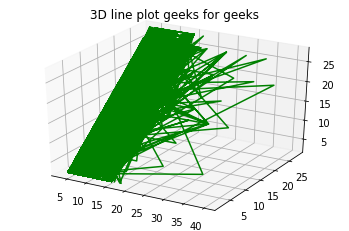

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
z = y
y = train_df['distance']
x= train_df['wait_time']
ax.plot3D(x, y, z, 'green')
ax.set_title('3D line plot geeks for geeks')
plt.show()

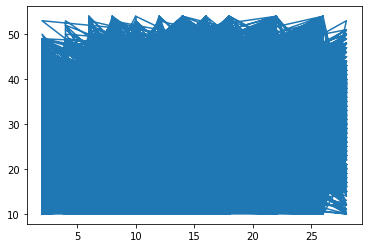

In [ ]:
fig = plt.figure()
plt.plot(train_df['distance'], y)
plt.show()

18

In [ ]:
#data processing - 1
def df_preprocess(df):

  age_mean = round(np.nanmean(df['Delivery_person_Age']))
  df['Delivery_person_Age'].fillna(age_mean,inplace=True)

  df['multiple_deliveries'].fillna(0.0,inplace=True)

  avg_rate = np.nanmean(df['Delivery_person_Ratings'])
  df['Delivery_person_Ratings'].fillna(round(avg_rate, 1),inplace=True)

  hr = str(int(np.median(list(map(lambda x: int(str(x).split(':')[0]),df['Time_Orderd'].dropna())))))
  min=str(int(np.median(list(map(lambda x: int(str(x).split(':')[1]),df['Time_Orderd'].dropna())))))
  df['Time_Orderd'].fillna(hr+':'+min,inplace=True)

  df['Road_traffic_density'].fillna('Medium',inplace=True)

  df['Festival'].fillna('No',inplace=True)
  df['City'].fillna('Urban',inplace=True)

  w_types  = df['Weather'].dropna().unique()
  for ind, row in df[df['Weather'].isna()].iterrows():
    df.at[ind,'Weather']  = r.choice(w_types)



  df.drop(['Unnamed: 0','Name:','ID','Delivery_person_ID','Type_of_order'],inplace =True,axis= 1)

  getdistance(df)
  waittime(df)

  df.drop(['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude','Time_Orderd','Time_Order_picked','Order_Date'],axis=1,inplace=True)
  
def df_transform(df):

  weather_le = pickle.load(open( r'/content/drive/MyDrive/datasets/weather_le.pkl', "rb" ))
  Road_traffic_density_le=pickle.load(open( r'/content/drive/MyDrive/datasets/Road_traffic_density_le.pkl', "rb" ))
  Type_of_vehicle_le=pickle.load(open( r'/content/drive/MyDrive/datasets/Type_of_vehicle_le.pkl', "rb" ))
  Festival_le=pickle.load(open( r'/content/drive/MyDrive/datasets/Festival_le.pkl', "rb" ))
  City_le=pickle.load(open( r'/content/drive/MyDrive/datasets/City_le.pkl', "rb" ))
  train_SS=pickle.load(open( r'/content/drive/MyDrive/datasets/train_SS.pkl', "rb" ))
  print(weather_le)
  df['Weather'] = weather_le.transform(df['Weather'])

  df['Road_traffic_density'] = Road_traffic_density_le.transform(df['Road_traffic_density'])

  df['Type_of_vehicle'] = Type_of_vehicle_le.transform(df['Type_of_vehicle'])

  df['Festival'] = Festival_le.transform(df['Festival'])

  df['City'] = City_le.transform(df['City'])
  df = train_SS.transform(df)

 

def predict(df):
  model = pickle.load(open( r'/content/drive/MyDrive/datasets/trained_model.pkl', "rb" ))
  return model.predict(df)



In [ ]:
train_df['Weather'].value_counts(dropna = False)

Fog           7741
Stormy        7681
Cloudy        7645
Sandstorms    7598
Windy         7536
Sunny         7392
Name: Weather, dtype: int64

In [ ]:
train_df[train_df['City'] == 'Metropolitian']['Weather'].value_counts()

Fog           5888
Cloudy        5769
Stormy        5664
Windy         5603
Sandstorms    5581
Sunny         5112
Name: Weather, dtype: int64

In [ ]:
train_df.isna().sum()

Unnamed: 0                        0
ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather                         616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken                        0
Name:                             0
dtype: int64

In [ ]:
test_df.isna().sum()

Unnamed: 0                       0
ID                               0
Delivery_person_ID               0
Delivery_person_Age            491
Delivery_person_Ratings        507
Restaurant_latitude              0
Restaurant_longitude             0
Delivery_location_latitude       0
Delivery_location_longitude      0
Order_Date                       0
Time_Orderd                    444
Time_Order_picked                0
Weather                        158
Road_traffic_density           154
Vehicle_condition                0
Type_of_order                    0
Type_of_vehicle                  0
multiple_deliveries            238
Festival                        65
City                           324
Name:                            0
dtype: int64

In [ ]:
train_df['Delivery_person_Age'].value_counts(dropna = False)

35.0    2262
36.0    2260
37.0    2227
30.0    2226
38.0    2219
24.0    2210
32.0    2202
22.0    2196
29.0    2191
33.0    2187
28.0    2179
25.0    2174
34.0    2166
26.0    2159
21.0    2153
27.0    2150
39.0    2144
20.0    2136
31.0    2120
23.0    2087
NaN     1854
50.0      53
15.0      38
Name: Delivery_person_Age, dtype: int64

In [ ]:
age_mean = round(np.nanmean(train_df['Delivery_person_Age']))
train_df['Delivery_person_Age'].fillna(age_mean,inplace=True)

In [ ]:
train_df['multiple_deliveries'].value_counts(dropna = False)

1.0    28159
0.0    14095
2.0     1985
NaN      993
3.0      361
Name: multiple_deliveries, dtype: int64

In [ ]:
train_df['multiple_deliveries'].fillna(0.0,inplace=True)

In [ ]:
avg_rate = np.nanmean(train_df['Delivery_person_Ratings'])
train_df['Delivery_person_Ratings'].fillna(round(avg_rate, 1),inplace=True)

In [ ]:
train_df['Time_Orderd'].value_counts(dropna = False)

NaN      1731
21:55     461
17:55     456
19:60     449
22:20     448
         ... 
12:25      57
14:15      56
15:60      53
13:20      52
16:30      51
Name: Time_Orderd, Length: 177, dtype: int64

In [ ]:
hr = str(int(np.median(list(map(lambda x: int(str(x).split(':')[0]),train_df['Time_Orderd'].dropna())))))
min=str(int(np.median(list(map(lambda x: int(str(x).split(':')[1]),train_df['Time_Orderd'].dropna())))))
train_df['Time_Orderd'].fillna(hr+':'+min,inplace=True)

In [ ]:
train_df['Weather'].value_counts(dropna = False)

Fog           7654
Stormy        7586
Cloudy        7536
Sandstorms    7495
Windy         7422
Sunny         7284
NaN            616
Name: Weather, dtype: int64

In [ ]:
train_df['Weather'].dropna(inplace=True)

In [ ]:
train_df['Road_traffic_density'].value_counts(dropna = False)

Low       15477
Jam       14143
Medium    10947
High       4425
NaN         601
Name: Road_traffic_density, dtype: int64

In [ ]:
train_df['Road_traffic_density'].fillna('Medium',inplace=True)

In [ ]:
train_df['Festival'].value_counts(dropna = False)

No     44469
Yes      896
NaN      228
Name: Festival, dtype: int64

In [ ]:
train_df['Festival'].fillna('No',inplace=True)

In [ ]:
train_df['City'].value_counts(dropna = False)

Metropolitian    34093
Urban            10136
NaN               1200
Semi-Urban         164
Name: City, dtype: int64

In [ ]:
print(np.mean(train_df[train_df['City'].isna()]['Time_taken']))
print(np.mean(train_df[train_df['City']=='Metropolitian']['Time_taken']))
print(np.mean(train_df[train_df['City']=='Urban']['Time_taken']))

22.058333333333334
27.315225999472034
22.984017363851617


In [ ]:
train_df['City'].fillna('Urban',inplace=True)

In [ ]:
train_df.dropna(inplace=True)

In [ ]:
train_df.isna().sum()

Unnamed: 0                     0
ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weather                        0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken                     0
Name:                          0
dtype: int64

In [ ]:
train_df.drop(['Unnamed: 0','Name:','ID','Delivery_person_ID','Type_of_order'],inplace =True,axis= 1)

In [ ]:
train_df.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30,11:45,Sunny,High,2,motorcycle,0.0,No,Urban,24.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45,19:50,Stormy,Jam,2,scooter,1.0,No,Metropolitian,33.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,8:30,8:45,Sandstorms,Low,0,motorcycle,1.0,No,Urban,26.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,17:60,18:10,Sunny,Medium,0,motorcycle,1.0,No,Metropolitian,21.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30,13:45,Cloudy,High,1,scooter,1.0,No,Metropolitian,30.0


In [ ]:
def getdistance(df):
  for ind,row in df.iterrows():
    res_lat = abs(row['Restaurant_latitude'])
    res_long = abs(row['Restaurant_longitude'])
    del_lat = abs(row['Delivery_location_latitude'])
    del_long = abs(row['Delivery_location_longitude'])
    distance = abs(res_lat-del_lat) + abs(res_long-del_long)
    df.at[ind,'distance'] = distance*100
getdistance(train_df)

In [ ]:
train_df[train_df['distance'] == max(train_df['distance'])]

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken,distance
219,26.0,4.9,26.911927,75.797282,27.051927,75.937282,29-03-2022,22:55,22:60,Stormy,Low,2,scooter,1.0,No,Metropolitian,18.0,28.0
226,36.0,4.4,26.846156,75.802300,26.986156,75.942300,29-03-2022,23:35,23:50,Fog,Low,0,motorcycle,0.0,No,Metropolitian,37.0,28.0
227,26.0,4.7,26.913987,75.752891,27.053987,75.892891,04-03-2022,19:35,19:40,Cloudy,Jam,0,motorcycle,1.0,No,Metropolitian,43.0,28.0
288,37.0,3.8,26.849596,75.800512,26.989596,75.940512,04-04-2022,20:45,20:55,Sandstorms,Jam,1,motorcycle,1.0,No,Metropolitian,42.0,28.0
467,30.0,4.3,26.888420,75.800689,27.028420,75.940689,18-03-2022,19:35,19:45,Windy,Jam,0,motorcycle,1.0,No,Urban,42.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45313,34.0,4.9,27.161661,78.011544,27.301661,78.151544,18-02-2022,22:15,22:30,Stormy,Low,0,motorcycle,1.0,No,Metropolitian,29.0,28.0
45369,20.0,4.9,26.891191,75.802083,27.031191,75.942083,02-03-2022,19:15,19:25,Windy,Jam,1,motorcycle,1.0,No,Metropolitian,25.0,28.0
45372,34.0,3.8,26.914142,75.805704,27.054142,75.945704,25-03-2022,19:45,19:60,Sandstorms,Jam,2,scooter,2.0,No,Urban,41.0,28.0
45405,30.0,4.6,26.470000,80.350000,26.610000,80.490000,12-02-2022,19:35,19:25,Windy,Jam,1,scooter,1.0,No,Metropolitian,18.0,28.0


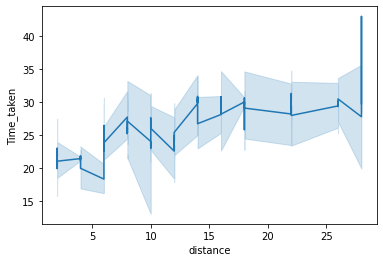

In [ ]:

sns.lineplot(x=train_df['distance'],y=train_df['Time_taken'])

In [ ]:
def diff(s1, s2):
    time1 = int(s1.replace(':',''))
    time2 = int(s2.replace(':',''))
    hourDiff = time2 // 100 - time1 // 100 - 1;
 
    minDiff = time2 % 100 + (60 - time1 % 100)
 
    if (minDiff >= 60):
        hourDiff += 1
        minDiff = minDiff - 60
 
    res = hourDiff*60  + minDiff
     
    return res

In [ ]:
def waittime(df):
  for ind,row in df.iterrows():
    total_min = diff(row['Time_Orderd'],row['Time_Order_picked'])
    if total_min < 0 or total_min >= row['Time_taken']-5:
      df.at[ind,'wait_time'] = row['Time_taken']*0.35
    elif total_min < 5 and row['Time_taken'] > 15:
      df.at[ind,'wait_time'] = 5
    else:
      df.at[ind,'wait_time'] = total_min
waittime(train_df)

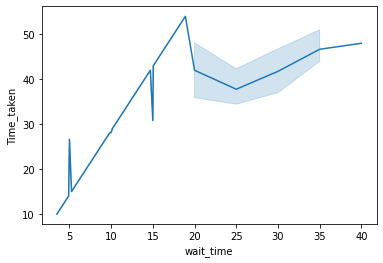

In [ ]:
sns.lineplot(x=train_df['wait_time'],y=train_df['Time_taken'])

In [ ]:
train_df.to_csv(r'/content/drive/MyDrive/datasets/train_with_extra.csv',index=False)

In [ ]:
train_df.drop(['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude','Time_Orderd','Time_Order_picked','Order_Date'],axis=1,inplace=True)

In [ ]:
train_df.to_csv(r'/content/drive/MyDrive/datasets/train_modified.csv',index=False)

In [ ]:
train_df.dtypes

Delivery_person_Age        float64
Delivery_person_Ratings    float64
Weather                     object
Road_traffic_density        object
Vehicle_condition            int64
Type_of_vehicle             object
multiple_deliveries        float64
Festival                    object
City                        object
Time_taken                 float64
distance                   float64
wait_time                  float64
dtype: object

In [ ]:
weather_le = LabelEncoder()
train_df['Weather'] = weather_le.fit_transform(train_df['Weather'])

Road_traffic_density_le = LabelEncoder()
train_df['Road_traffic_density'] = Road_traffic_density_le.fit_transform(train_df['Road_traffic_density'])

Type_of_vehicle_le  = LabelEncoder()
train_df['Type_of_vehicle'] = Type_of_vehicle_le.fit_transform(train_df['Type_of_vehicle'])

Festival_le = LabelEncoder()
train_df['Festival'] = Festival_le.fit_transform(train_df['Festival'])

City_le = LabelEncoder()
train_df['City'] = City_le.fit_transform(train_df['City'])


In [ ]:
pickle.dump(weather_le,open( r'/content/drive/MyDrive/datasets/weather_le.pkl', "wb" ))
pickle.dump(Road_traffic_density_le,open( r'/content/drive/MyDrive/datasets/Road_traffic_density_le.pkl', "wb" ))
pickle.dump(Type_of_vehicle_le,open( r'/content/drive/MyDrive/datasets/Type_of_vehicle_le.pkl', "wb" ))
pickle.dump(Festival_le,open( r'/content/drive/MyDrive/datasets/Festival_le.pkl', "wb" ))
pickle.dump(City_le,open( r'/content/drive/MyDrive/datasets/City_le.pkl', "wb" ))
pickle.dump(train_SS,open( r'/content/drive/MyDrive/datasets/train_SS.pkl', "wb" ))

In [ ]:
Time_taken = train_df['Time_taken']
train_df.drop(['Time_taken'],axis=1,inplace=True)
train_SS = StandardScaler()
train_df = train_SS.fit_transform(train_df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.33, random_state=5)

In [ ]:
lr = LinearRegression()
lr.fit(train_df,y)
lr_pred = lr.predict(train_df)
print('r2 score',r2_score(y, lr_pred))
print('mean_squared_error',mean_squared_error(y, lr_pred))

r2 score 0.5511504627494289
mean_squared_error 39.52294617492492


r2 score 0.61737363413033
mean_squared_error 33.659013505392906


In [ ]:
lasso = Lasso()
lasso.fit(train_df,y)
lasso_pred = lasso.predict(train_df)
print('r2 score',r2_score(y, lasso_pred))
print('mean_squared_error',mean_squared_error(y, lasso_pred))

r2 score 0.5205411390945323
mean_squared_error 42.21821608357579


In [ ]:
ridge = Ridge()
ridge.fit(X_train,y_train)
ridge_pred = lasso.predict(X_test)
print('r2 score',r2_score(y_test, ridge_pred))
print('mean_squared_error',mean_squared_error(y_test, ridge_pred))

r2 score 0.5237450992481476
mean_squared_error 42.018000075195275


In [ ]:
poly_df = PolynomialFeatures(degree = 3)
train_poly = poly_df.fit_transform(train_df)
#test_poly = poly_df.transform(X_test)

linreg2 = LinearRegression()
linreg2.fit(train_poly,y)

polynomial_predict = linreg2.predict(train_poly)

print('r2 score',r2_score(y, polynomial_predict))
print('mean_squared_error',mean_squared_error(y, polynomial_predict))

r2 score 0.7095885889861744
mean_squared_error 25.571853401902608


In [ ]:
for i in range(2,20):
  print('n =',i)
  knnr = KNeighborsRegressor(n_neighbors= i)
  knnr.fit(train_df,y)
  knnr_pred = knnr.predict(train_df)
  print('r2 score',r2_score(y, knnr_pred))
  print('mean_squared_error',mean_squared_error(y, knnr_pred))

n = 2
r2 score 0.9132943609289018
mean_squared_error 7.634768495163732
n = 3
r2 score 0.8809557825030755
mean_squared_error 10.482306007013747
n = 4


KeyboardInterrupt: ignored

In [ ]:
print('n =',2)
knnr = KNeighborsRegressor(n_neighbors= 2)
knnr.fit(train_df,y)
knnr_pred = knnr.predict(train_df)
print('r2 score',r2_score(y, knnr_pred))
print('mean_squared_error',mean_squared_error(y, knnr_pred))

n = 2
r2 score 0.9132943609289018
mean_squared_error 7.634768495163732


In [ ]:
knnr_pred = knnr.predict(X_train)
print('r2 score',r2_score(y_train, knnr_pred))
print('mean_squared_error',mean_squared_error(y_train, knnr_pred))

r2 score 0.8245871395990864
mean_squared_error 15.430781472244512


In [ ]:
svr = SVR()
svr.fit(train_df,y)
svr_pred = svr.predict(train_df)
print('r2 score',r2_score(y, svr_pred))
print('mean_squared_error',mean_squared_error(y, svr_pred))

r2 score 0.6980003090776898
mean_squared_error 26.592246484824106


In [ ]:
svr_pred = svr.predict(X_train)
print('r2 score',r2_score(y_train, svr_pred))
print('mean_squared_error',mean_squared_error(y_train, svr_pred))

r2 score 0.7744288018459344
mean_squared_error 19.843128133207387


In [ ]:
pickle.dump(knnr,open( r'/content/drive/MyDrive/datasets/trained_model.pkl', "wb" ))

In [ ]:
df = train_df.copy()
df_preprocess(df)
y = df['Time_taken']
df.drop(['Time_taken'],inplace = True, axis=1)
out = df_transform(df)

X_train, X_test, y_train, y_test = train_test_split(out, y, test_size=0.33, random_state=5)

LabelEncoder()


In [ ]:
def predictwithmodel(X_data,Y_data,model,**kwags):
  if model == KNeighborsRegressor():
    k = kwags['k']
    print(k)
  else:
    print(kwags)

In [ ]:
predictwithmodel(1,2,KNeighborsRegressor(),k=1)

{'k': 1}


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow import keras

In [ ]:
# temp = None
# for i in range(5):
# create ANN model
model = Sequential()

model.add(Dense(units=32, input_dim=len(train_df[0]), kernel_initializer='normal', activation='tanh'))

model.add(Dense(units=16, kernel_initializer='normal', activation='tanh'))

#model.add(Dense(units=8, kernel_initializer='normal', activation='tanh'))

#model.add(Dense(units=4, kernel_initializer='normal', activation='tanh'))

model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='sgd')
# if temp:
#   model.set_weights(temp.get_weights()) 

model.fit(train_df, y ,batch_size = 15, epochs = 300, verbose=1)
temp = model

Epoch 1/300
3040/3040 [==============================] - 7s 2ms/step - loss: 27.1370
Epoch 2/300
3040/3040 [==============================] - 7s 2ms/step - loss: 17.5690
Epoch 3/300
3040/3040 [==============================] - 7s 2ms/step - loss: 15.7285
Epoch 4/300
3040/3040 [==============================] - 7s 2ms/step - loss: 14.7932
Epoch 5/300
3040/3040 [==============================] - 7s 2ms/step - loss: 14.3192
Epoch 6/300
3040/3040 [==============================] - 7s 2ms/step - loss: 13.9784
Epoch 7/300
3040/3040 [==============================] - 7s 2ms/step - loss: 13.7368
Epoch 8/300
3040/3040 [==============================] - 7s 2ms/step - loss: 13.5226
Epoch 9/300
3040/3040 [==============================] - 7s 2ms/step - loss: 13.5497
Epoch 10/300
3040/3040 [==============================] - 7s 2ms/step - loss: 13.2760
Epoch 11/300
3040/3040 [==============================] - 7s 2ms/step - loss: 13.3251
Epoch 12/300
3040/3040 [==============================] - 7s 2m

In [ ]:
dl_pred  = model.predict(train_df)
print('r2 score',r2_score(y, dl_pred))
print('mean_squared_error',mean_squared_error(y, dl_pred))

r2 score 0.8771767468381871
mean_squared_error 10.815064784245427


In [ ]:
train_df = df_preprocess(train_df)
train_df = df_transform(train_df)

In [ ]:
IDs = test_df['ID']
test_df = df_preprocess(test_df)
test_df = df_transform(test_df)
dl_pred  = model.predict(test_df)

In [ ]:
result = pd.DataFrame(columns = ['ID','Time_taken (min)'])
result['ID'] = IDs
for ind,row in result.iterrows():
  result.at[ind,'Time_taken (min)'] = dl_pred[ind][0]


In [ ]:
result.to_csv(r'/content/drive/MyDrive/datasets/submission.csv',index=False)

In [ ]:
result

,ID,Time_taken (min)
0,0x2318,16.142857
1,0x3474,29.0
2,0x9420,31.714286
3,0x72ee,23.285714
4,0xa759,18.285714
...,...,...
11394,0x6909,25.571429
11395,0x443b,28.142857
11396,0x1ea5,21.428571
11397,0x22d4,31.428571
